# Text Extraction from Images

## Loading the main libraries

In [1]:
import numpy as np
from PIL import Image
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'D:\Program Files (x86)\Tesseract\tesseract.exe'
from pytesseract import Output
import re
import requests
from IPython.display import HTML, clear_output

In [2]:
# Downloading tesseract-ocr file
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream = True)  
  
# Writing data to file to avoid path issues
with open("ind.traineddata", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:
                file.write(block)

## Loading a sample image

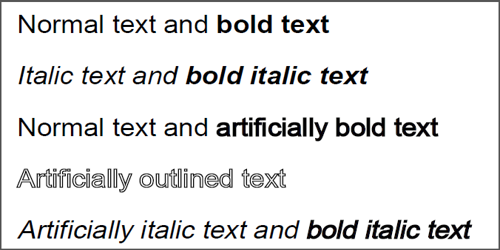

In [3]:
image = Image.open(requests.get('https://i.stack.imgur.com/pbIdS.png', stream=True).raw)
image = image.resize((500,250))
image.save('sample.png')
image

## Extracting text from the image

In [4]:
custom_config = r'-l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image, config=custom_config)
print(text)

Normal text and bold text

Italic text and bold italic text

Normal text and artificially bold text
Artificially outlined text

Artificially italic text and bold italic text



In [5]:
try:
    text = pytesseract.image_to_string(image, lang='eng')
    characters_to_remove = "!()@—*“>+-/,'|£#%$&^_~"
    new_string = text
    for character in characters_to_remove:
        new_string = new_string.replace(character, "")
    print(new_string)
except IOError as e:
    print(f"Error ({e})")

Normal text and bold text

Italic text and bold italic text

Normal text and artificially bold text
Artificially outlined text

Artificially italic text and bold italic text




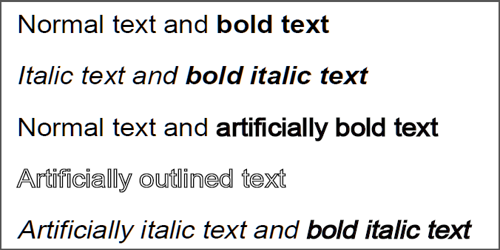

In [6]:
image = cv2.imread('sample.png')
Image.fromarray(image)

## Creating a function to convert images to grayscale

In [7]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

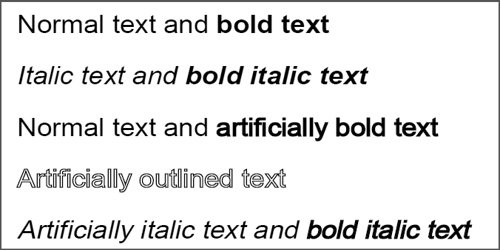

In [8]:
gray = get_grayscale(image)
Image.fromarray(gray)

### • Converting images to grayscale makes the image less complex to process

## Creating a function to blur images

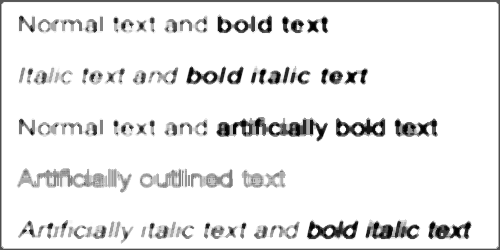

In [9]:
def remove_noise(image):
    return cv2.medianBlur(image, 5)
noise = remove_noise(gray)
Image.fromarray(noise)

## Creating a function to perform threshold transformation

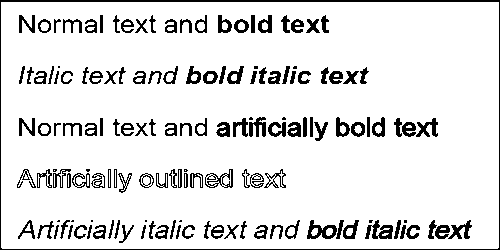

In [10]:
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

thresh = thresholding(gray)
Image.fromarray(thresh)

### • If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value
### • The first argument is the source image, which should be a grayscale image
### • The second argument is the threshold value which is used to classify the pixel values
### • The third argument is the maximum value which is assigned to pixel values exceeding the threshold

## Creating a function to erode the image

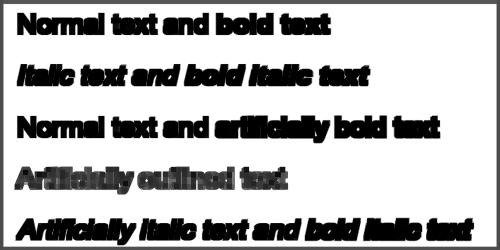

In [11]:
def erode(image):
    kernel = np.ones((5,5), np.uint8)
    return cv2.erode(image, kernel, iterations=1)

erode = erode(gray)
Image.fromarray(erode)

### • The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white)
### • The kernel slides through the image (as in 2D convolution)
### • A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero)

## Creating a function to perform image opening

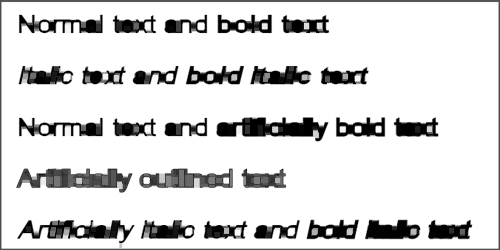

In [12]:
def opening(image):
    kernel = np.ones((5,5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

opening = opening(gray)
Image.fromarray(opening)

### • Opening is just another name of erosion followed by dilation 
### • It is useful in opening small holes inside the foreground objects, or small white points on the object

## Creating a function to detect the edges of an image

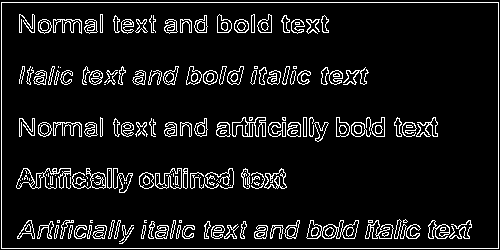

In [13]:
def canny(image):
    return cv2.Canny(image, 100, 200)

canny = canny(gray)
Image.fromarray(canny)

### • Canny Edge Detection is a popular edge detection algorithm
### • First argument is our input image
### • Second and third arguments are our minVal and maxVal respectively
### • Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded
### • Those who lie between these two thresholds are classified edges or non-edges based on their connectivity
### • If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded

## Creating a function to perform skew correction on an image

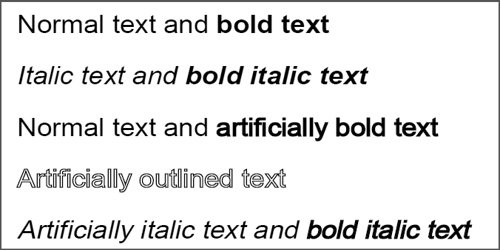

In [14]:
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w,h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

rotated = deskew(gray)
Image.fromarray(rotated)

### • Deskewing is a process whereby skew is removed by rotating an image by the same amount as its skew but in the opposite direction
### • This results in a horizontally and vertically aligned image where the text runs across the page rather than at an angle

## Creating a function for template matching

In [15]:
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

match = match_template(gray, gray)
# Similarity is 1 due to using the same image for both hyperparameters
match

array([[1.]], dtype=float32)

### • Template matching is a method for searching and finding the location of a template image in a larger image
### • It slides the template image over the input image (as in 2D convolution) and compares the template and patch of input image under the template image

## Creating a function 

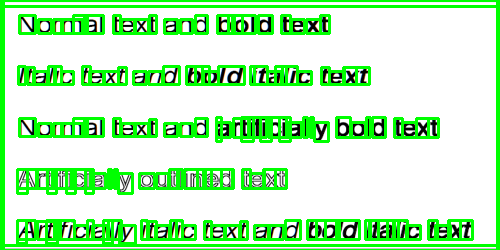

In [23]:
image = cv2.imread('sample.png')
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image)
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0,255,0), 2)
Image.fromarray(image)

### • We have segregated every character by creating a rectangle around it

## Drawing pattern on specific pattern or word

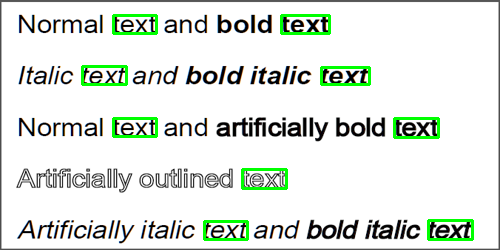

In [46]:
image = cv2.imread('sample.png')
d = pytesseract.image_to_data(image, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = 'text'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if eval(d['conf'][i]) > 60:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
            
Image.fromarray(image)